# UIUC Grid Demand: Demand + Solar Elevation Angle

This notebook uses an Echo State Network(ESN) (from pyESN) to predict the demand at the University of Illinois.
Rather than one input, there are two inputs: Demand and Solar Elevation Angle. 
The following items are included:

1. An initial demonstration of the ESN with a 72-hour prediction.
2. Grid optimization over spectral radius and noise
3. Grid optimization over reservoir size and sparsity
4. Demonstrate the effect of training length on accuracy.
5. A final demonstration of the ESN with optimized hyper-parameters.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, "/home/dotson/research/cairo")


# custom libraries
from tools import MSE, esn_prediction, param_string, optimal_values
from optimizers import grid_optimizer
from sunrise import generate_elevation_series
from pyESN.pyESN import ESN

In [2]:
start = "11/1/2016"
end = "1/1/2019"

In [3]:
# import demand data
df_demand = pd.read_csv("../data/uiuc_demand_data.csv", usecols=['time','kw'])
df_demand.time = pd.to_datetime(df_demand.time)
dm_mask = (df_demand['time'] > pd.to_datetime(start)) & (df_demand['time'] < pd.to_datetime(end))
df_demand = df_demand[dm_mask]
df_demand = np.array(df_demand.kw).astype('float64')


# normalize
norm_t = np.linalg.norm(df_demand)
tot_norm = df_demand/norm_t

In [4]:
# import demand data
dataframe = pd.read_csv("../data/uiuc_net_demand.csv", usecols=['time','kw'])
demand = np.array(dataframe.kw).astype('float64')

# normalize
norm = np.linalg.norm(demand)
demand_norm = demand/norm

In [5]:
time_range = pd.date_range(start='11/1/2016', end='1/1/2019', freq='h')[:-2]
elevation = generate_elevation_series(time_range, timestamps=True)
norm_a = np.linalg.norm(elevation)
angles_norm = elevation/norm_a
print(f"Norm of elevation angles: {norm_a}")
print(f"Norm of demand: {norm}")

Norm of elevation angles: 4989.965502674148
Norm of demand: 6525386.935849079


## Format the Input Data

In [6]:
X_in = np.concatenate([[demand_norm, angles_norm]], axis=1)
    
print(f"Shape of X_in is {X_in.shape}")

Shape of X_in is (2, 18983)


In [7]:
params = {'n_reservoir':1000, 
          'sparsity':0.1, 
          'rand_seed':85, 
          'rho':1.5, 
          'noise':0.0001, 
          'future':72, 
          'window':72, 
          'trainlen':8000}

In [8]:
futureTotal = params['future']
hour_range = np.arange(0, len(time_range), 1)

## 1. Initial Demonstration


In [9]:
tic = time.perf_counter()

init_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 4.45 seconds
This simulation took 0.07 minutes


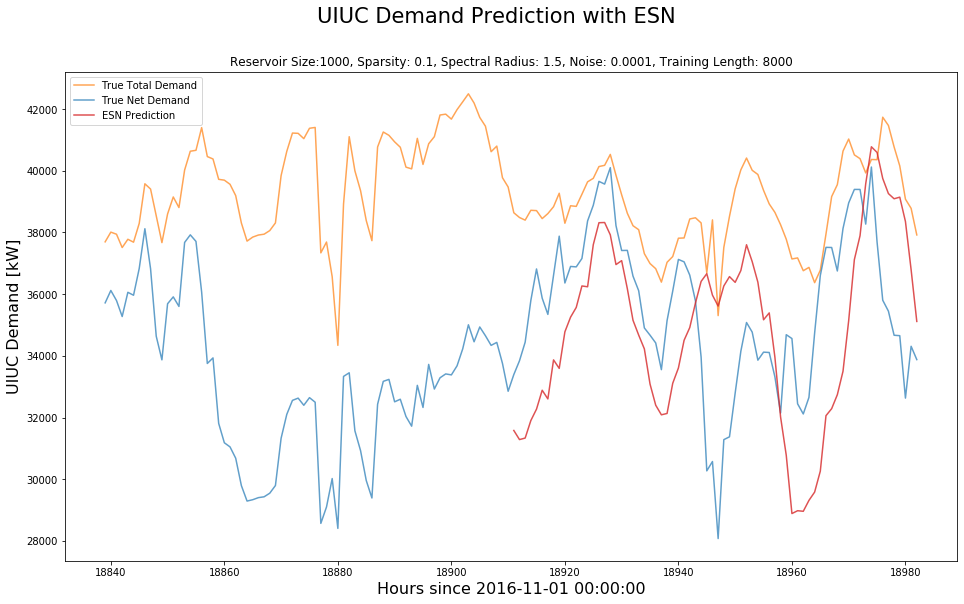

In [10]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm_t*tot_norm[-2*futureTotal:],'b',label="True Total Demand", 
         alpha=0.7,
         color='tab:orange')
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Net Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*init_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

In [11]:
rand_seeds = [85, 21, 22, 30, 122, 5, 79]

N = len(rand_seeds)
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 21.29 seconds
This simulation took 0.35 minutes


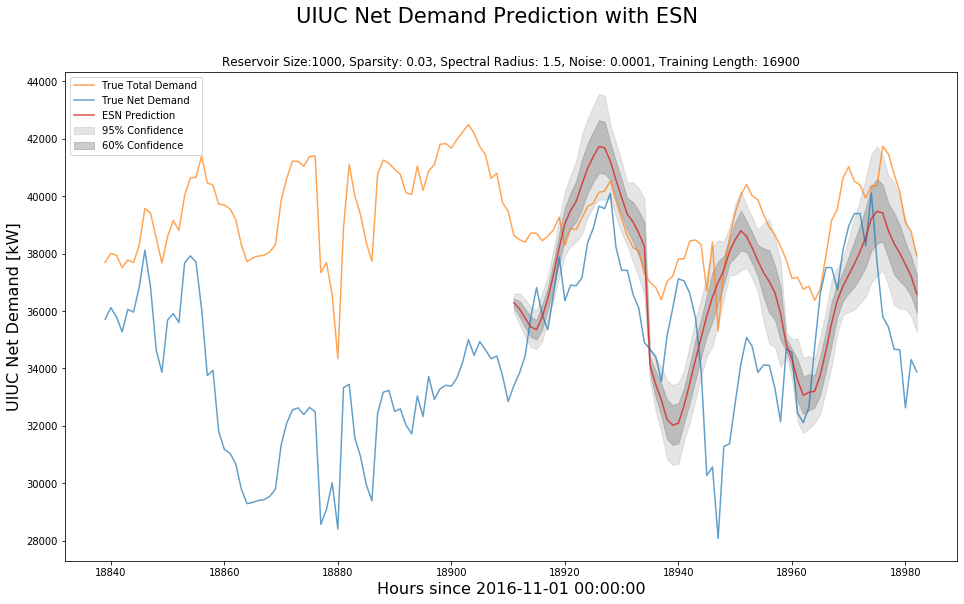

In [43]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Net Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Net Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm_t*tot_norm[-2*futureTotal:],'b',label="True Total Demand", 
         alpha=0.7,
         color='tab:orange')
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Net Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + 2 * std_prediction),
                 norm*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + std_prediction),
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()

### 2. Grid Optimization Over Spectral Radius and Noise

Optimizing over ['rho', 'noise']:
rho = 0.5, noise = 0.0001, MSE=0.0035549415492978835
rho = 0.5, noise = 0.0003, MSE=0.0038259871296829084
rho = 0.5, noise = 0.0007, MSE=0.003390765438636656
rho = 0.5, noise = 0.001, MSE=0.0033133472676307586
rho = 0.5, noise = 0.003, MSE=0.004041121060511437
rho = 0.5, noise = 0.005, MSE=0.0048571052108926874
rho = 0.5, noise = 0.007, MSE=0.005628699472988241
rho = 0.5, noise = 0.01, MSE=0.006402132388076613
rho = 0.7, noise = 0.0001, MSE=0.003265316742610576
rho = 0.7, noise = 0.0003, MSE=0.004061582804016771
rho = 0.7, noise = 0.0007, MSE=0.0038268494151910983
rho = 0.7, noise = 0.001, MSE=0.003543879312381641
rho = 0.7, noise = 0.003, MSE=0.003914591371366411
rho = 0.7, noise = 0.005, MSE=0.004776891242521567
rho = 0.7, noise = 0.007, MSE=0.005467599945551107
rho = 0.7, noise = 0.01, MSE=0.006238807060181671
rho = 0.9, noise = 0.0001, MSE=0.0023786472968183327
rho = 0.9, noise = 0.0003, MSE=0.003409620548282732
rho = 0.9, noise = 0.0007, MSE=0.004

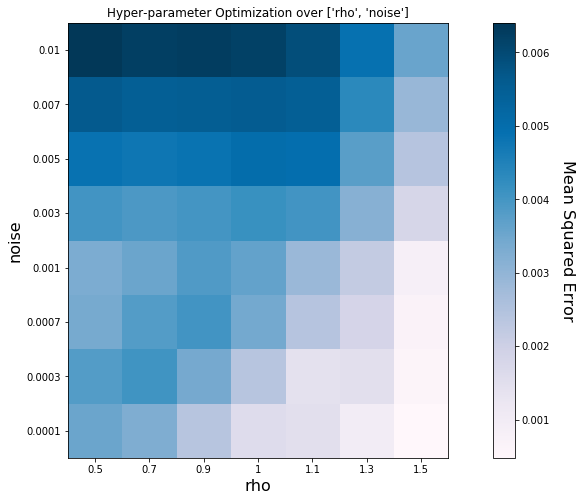

In [13]:
tic = time.perf_counter()
radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]

radiusxnoise_loss = grid_optimizer(X_in.T,
                      params,
                      args=['rho', 'noise'],
                      xset=radius_set,
                      yset=noise_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [14]:
opt_radius, opt_noise = optimal_values(radiusxnoise_loss, radius_set, noise_set)
params['rho'] = opt_radius
params['noise'] = opt_noise
print(f'The optimal set is:\nspectrum radius = {opt_radius} \nnoise = {opt_noise}')

The optimal set is:
spectrum radius = 1.5 
noise = 0.0001


### 3. Grid Optimization Over Reservoir Size and Sparsity

The algorithm is unstable when ``n_reservoir == trainlen``.

Optimizing over ['n_reservoir', 'sparsity']:
n_reservoir = 600, sparsity = 0.005, MSE=0.0006095630540704668
n_reservoir = 600, sparsity = 0.01, MSE=0.0006205469202921444
n_reservoir = 600, sparsity = 0.03, MSE=0.000610861309696045
n_reservoir = 600, sparsity = 0.05, MSE=0.0005664052915348702
n_reservoir = 600, sparsity = 0.1, MSE=0.000608493052950805
n_reservoir = 600, sparsity = 0.15, MSE=0.0004601550178503963
n_reservoir = 600, sparsity = 0.2, MSE=0.0004432462103729174
n_reservoir = 800, sparsity = 0.005, MSE=0.0005672517319174581
n_reservoir = 800, sparsity = 0.01, MSE=0.000488695265868467
n_reservoir = 800, sparsity = 0.03, MSE=0.0004886553877833477
n_reservoir = 800, sparsity = 0.05, MSE=0.0005334120398858765
n_reservoir = 800, sparsity = 0.1, MSE=0.0005527449632271247
n_reservoir = 800, sparsity = 0.15, MSE=0.0005635233424671073
n_reservoir = 800, sparsity = 0.2, MSE=0.0005272518415725768
n_reservoir = 1000, sparsity = 0.005, MSE=0.0005567312756910519
n_reservoir = 1000, sparsity

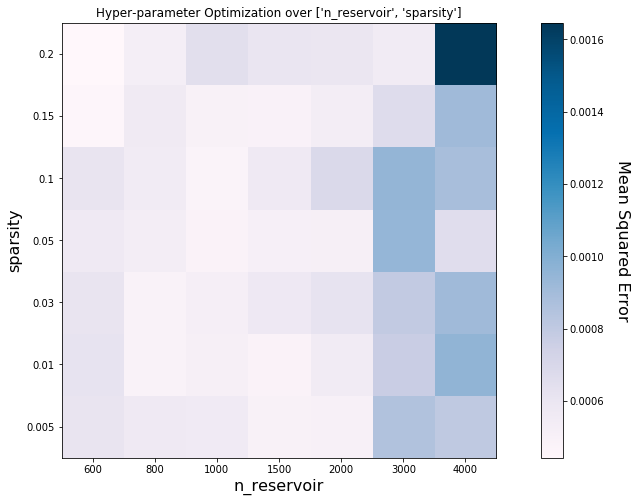

In [15]:
tic = time.perf_counter()
reservoir_set = [600, 800, 1000, 1500, 2000, 3000, 4000]
sparsity_set = [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

sizexsparsity_loss = grid_optimizer(X_in.T,
                      params,
                      args=['n_reservoir', 'sparsity'],
                      xset=reservoir_set,
                      yset=sparsity_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [16]:
opt_size, opt_sparsity = optimal_values(sizexsparsity_loss, reservoir_set, sparsity_set)
params['n_reservoir'] = opt_size
params['sparsity'] = opt_sparsity
print(f'The optimal set is:\nreservoir size = {opt_size} \nsparsity = {opt_sparsity}')

The optimal set is:
reservoir size = 600 
sparsity = 0.2


### 4. Demonstrate the Effect of Training Length

Once again, the algorithm is unstable when ``n_reservoir == trainlen``.

We should expect that MSE will decrease as training length increases.

Optimizing over ['trainlen']:
trainlen = 5000, MSE=0.0005434033217713267
trainlen = 5300, MSE=0.0005854307483343811
trainlen = 5600, MSE=0.0004480279047514184
trainlen = 5900, MSE=0.0006896923098745264
trainlen = 6200, MSE=0.0005118383918559925
trainlen = 6500, MSE=0.0006128350803221516
trainlen = 6800, MSE=0.0004969511086134399
trainlen = 7100, MSE=0.0006646054562054674
trainlen = 7400, MSE=0.0005682098168866941
trainlen = 7700, MSE=0.000543186672091206
trainlen = 8000, MSE=0.0004432462103729174
trainlen = 8300, MSE=0.00048665230984149953
trainlen = 8600, MSE=0.0005028947225025858
trainlen = 8900, MSE=0.0004318344261439273
trainlen = 9200, MSE=0.0004875651878637528
trainlen = 9500, MSE=0.00046062337055538717
trainlen = 9800, MSE=0.0004288522361670126
trainlen = 10100, MSE=0.0004730472047787999
trainlen = 10400, MSE=0.0004517168712290908
trainlen = 10700, MSE=0.00046899974346656603
trainlen = 11000, MSE=0.0004680238892524569
trainlen = 11300, MSE=0.0005281554789415527
trainlen = 11600,

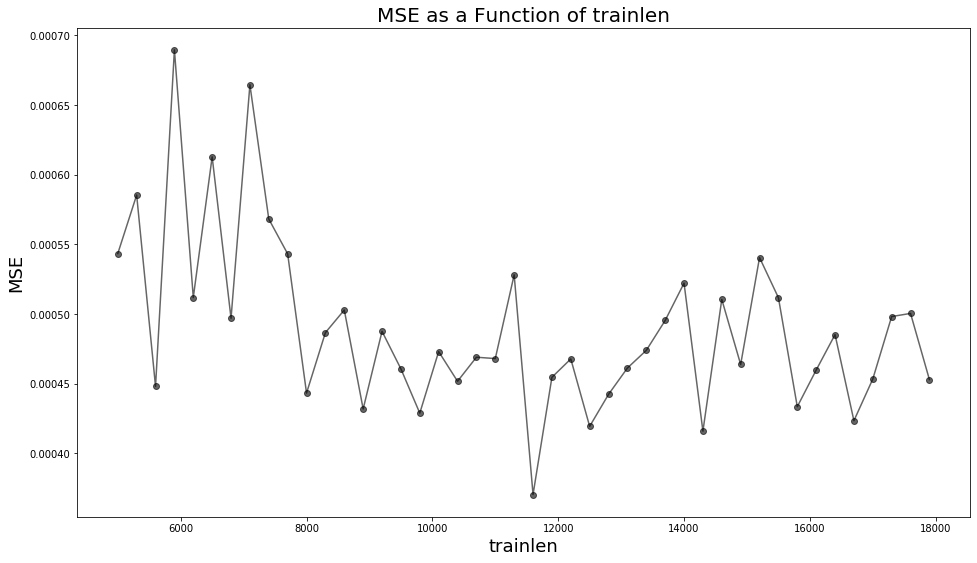

In [18]:
tic = time.perf_counter()
trainingLengths = np.arange(5000,18000,300)
trainlen_loss = grid_optimizer(X_in.T,
                      params,
                      args=['trainlen'],
                      xset=trainingLengths,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds") 
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [19]:
minloss = np.min(trainlen_loss)
index_min = np.where(trainlen_loss == minloss)
l_opt = trainingLengths[index_min][0]
params['trainlen'] = l_opt

print(f"Training length with minimum error was: {l_opt}")

Training length with minimum error was: 11600


### 5. Optimized Demand Prediction


In [20]:
tic = time.perf_counter()

opt_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 1.35 seconds
This simulation took 0.02 minutes


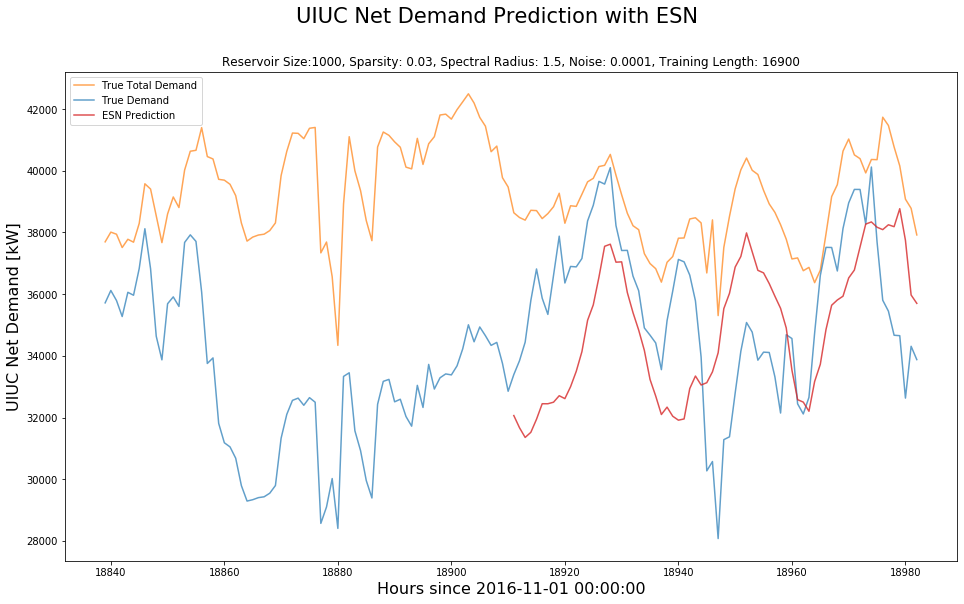

In [42]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Net Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Net Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm_t*tot_norm[-2*futureTotal:],'b',label="True Total Demand", 
         alpha=0.7,
         color='tab:orange')
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*opt_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 6. Uncertainty Calculation

In [22]:
rand_seeds = [85, 21, 22, 30, 122, 5, 79]

N = len(rand_seeds)
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 11.89 seconds
This simulation took 0.20 minutes


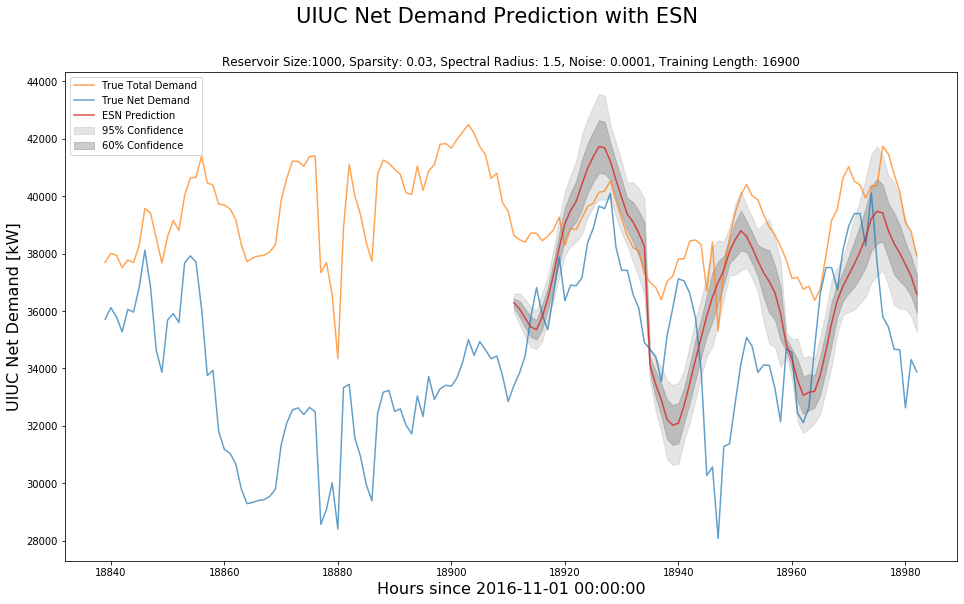

In [41]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Net Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Net Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm_t*tot_norm[-2*futureTotal:],'b',label="True Total Demand", 
         alpha=0.7,
         color='tab:orange')
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Net Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + 2 * std_prediction),
                 norm*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + std_prediction),
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()

### 7. Reduce Window Size

In [28]:
params['window'] = 12
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 48.44 seconds
This simulation took 0.81 minutes


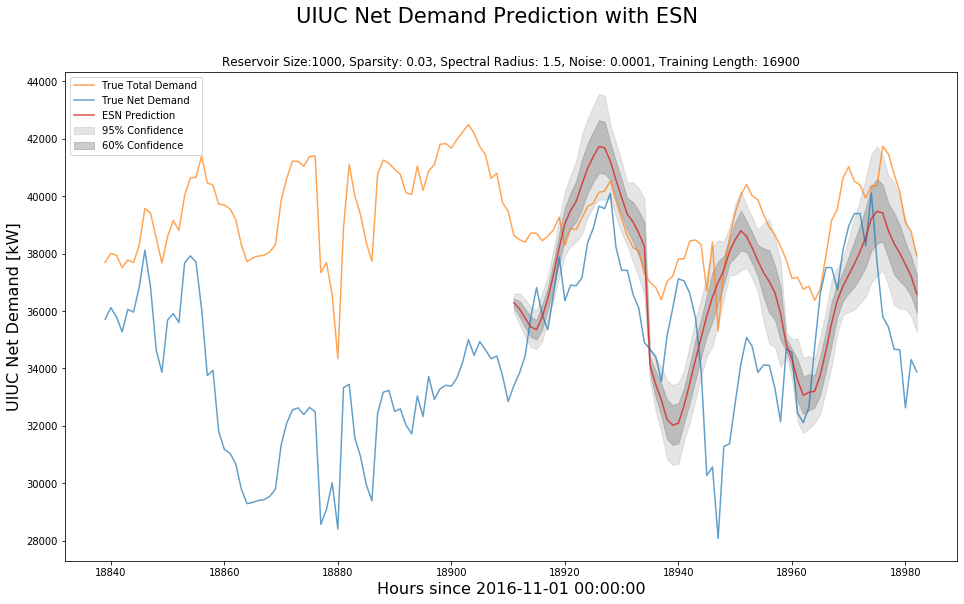

In [40]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Net Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Net Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm_t*tot_norm[-2*futureTotal:],'b',label="True Total Demand", 
         alpha=0.7,
         color='tab:orange')
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Net Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + 2 * std_prediction),
                 norm*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + std_prediction),
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4, label='60% Confidence')
plt.legend()

### 8. Demand Prediction With This Shorter Dataset

In [49]:
X2_in = np.concatenate([[tot_norm, angles_norm]], axis=1)

params = {'n_reservoir':1000, 
          'sparsity':0.07, 
          'rand_seed':85, 
          'rho':1.3, 
          'noise':0.001, 
          'future':72, 
          'window':72, 
          'trainlen':16900}

In [50]:
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X2_in.T, params)
    predictions[x] = prediction.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 27.01 seconds
This simulation took 0.45 minutes


In [51]:
mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

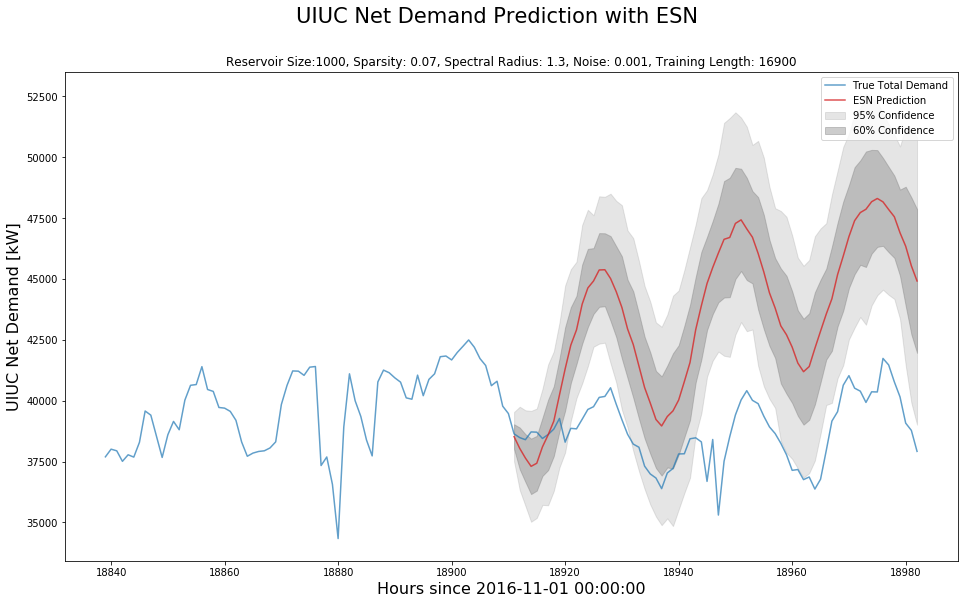

In [52]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Net Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Net Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm_t*tot_norm[-2*futureTotal:],'b',label="True Total Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm_t*mean_prediction,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm_t*(mean_prediction + 2 * std_prediction),
                 norm_t*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm_t*(mean_prediction + std_prediction),
                 norm_t*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4, label='60% Confidence')
plt.legend()